# Proyek Machine Learning - Prediksi Harga Rumah

Notebook ini berisi implementasi proyek machine learning untuk memprediksi harga rumah berdasarkan berbagai fitur. Proyek ini menggunakan dataset rumah yang tersedia secara publik dengan penerapan teknik-teknik machine learning.

## Import Library
Pada bagian ini, kita akan mengimport library yang diperlukan untuk analisis data dan pemodelan.

In [23]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

## 1. Data Understanding
Pada bagian ini, kita akan mengunduh dan memahami dataset yang akan digunakan.

In [2]:
# Download dataset
import os
from sklearn.datasets import fetch_california_housing

# Mengunduh dataset California Housing
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()
df['MedHouseVal'] = df['MedHouseVal'] * 100000  # Konversi ke USD

# Cek beberapa baris pertama data
print("Dimensi dataset:", df.shape)
df.head()

Dimensi dataset: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,452600.0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,358500.0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,352100.0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,341300.0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,342200.0


### Deskripsi Dataset

Dataset California Housing berisi informasi tentang harga rumah di berbagai distrik di California pada tahun 1990. Dataset ini mencakup 20.640 sampel dengan 8 fitur dan 1 target.

Berikut adalah deskripsi dari setiap variabel:

In [3]:
# Membuat deskripsi data
feature_names = housing.feature_names
target_name = housing.target_names[0]
descriptions = housing.DESCR

# Membuat dataframe yang berisi informasi fitur
features_info = pd.DataFrame({
    'Fitur': feature_names,
    'Deskripsi': [
        'Median pendapatan rumah tangga dalam blok (dalam USD 10,000)',
        'Median usia rumah dalam blok',
        'Rata-rata jumlah kamar per rumah tangga',
        'Rata-rata jumlah kamar tidur per rumah tangga',
        'Populasi blok',
        'Rata-rata jumlah anggota rumah tangga',
        'Garis lintang blok',
        'Garis bujur blok'
    ]
})

# Menampilkan informasi fitur
features_info

,Fitur,Deskripsi
0,MedInc,Median pendapatan rumah tangga dalam blok (dal...
1,HouseAge,Median usia rumah dalam blok
2,AveRooms,Rata-rata jumlah kamar per rumah tangga
3,AveBedrms,Rata-rata jumlah kamar tidur per rumah tangga
4,Population,Populasi blok
5,AveOccup,Rata-rata jumlah anggota rumah tangga
6,Latitude,Garis lintang blok
7,Longitude,Garis bujur blok


### Eksplorasi Data Awal

Mari kita lakukan eksplorasi data untuk memahami karakteristiknya:

In [4]:
# Analisis statistik dasar
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,206855.816909
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,115395.615874
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,14999.000000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,119600.000000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,179700.000000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,264725.000000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,500001.000000


In [5]:
# Cek missing values
print("Jumlah nilai yang hilang per kolom:")
df.isnull().sum()

Jumlah nilai yang hilang per kolom:


,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


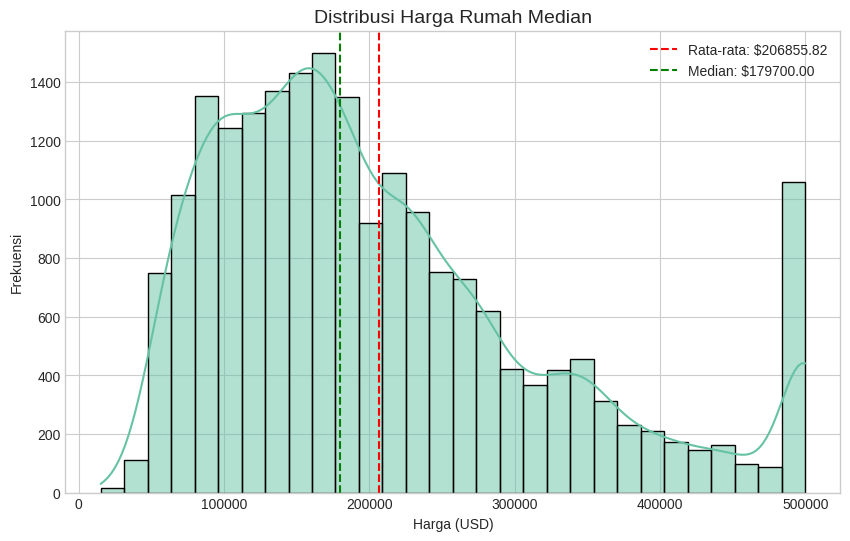

In [6]:
# Visualisasi distribusi harga rumah
plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseVal'], kde=True, bins=30)
plt.title('Distribusi Harga Rumah Median', fontsize=14)
plt.xlabel('Harga (USD)')
plt.ylabel('Frekuensi')
plt.axvline(df['MedHouseVal'].mean(), color='r', linestyle='--', label=f'Rata-rata: ${df["MedHouseVal"].mean():.2f}')
plt.axvline(df['MedHouseVal'].median(), color='g', linestyle='--', label=f'Median: ${df["MedHouseVal"].median():.2f}')
plt.legend()
plt.show()

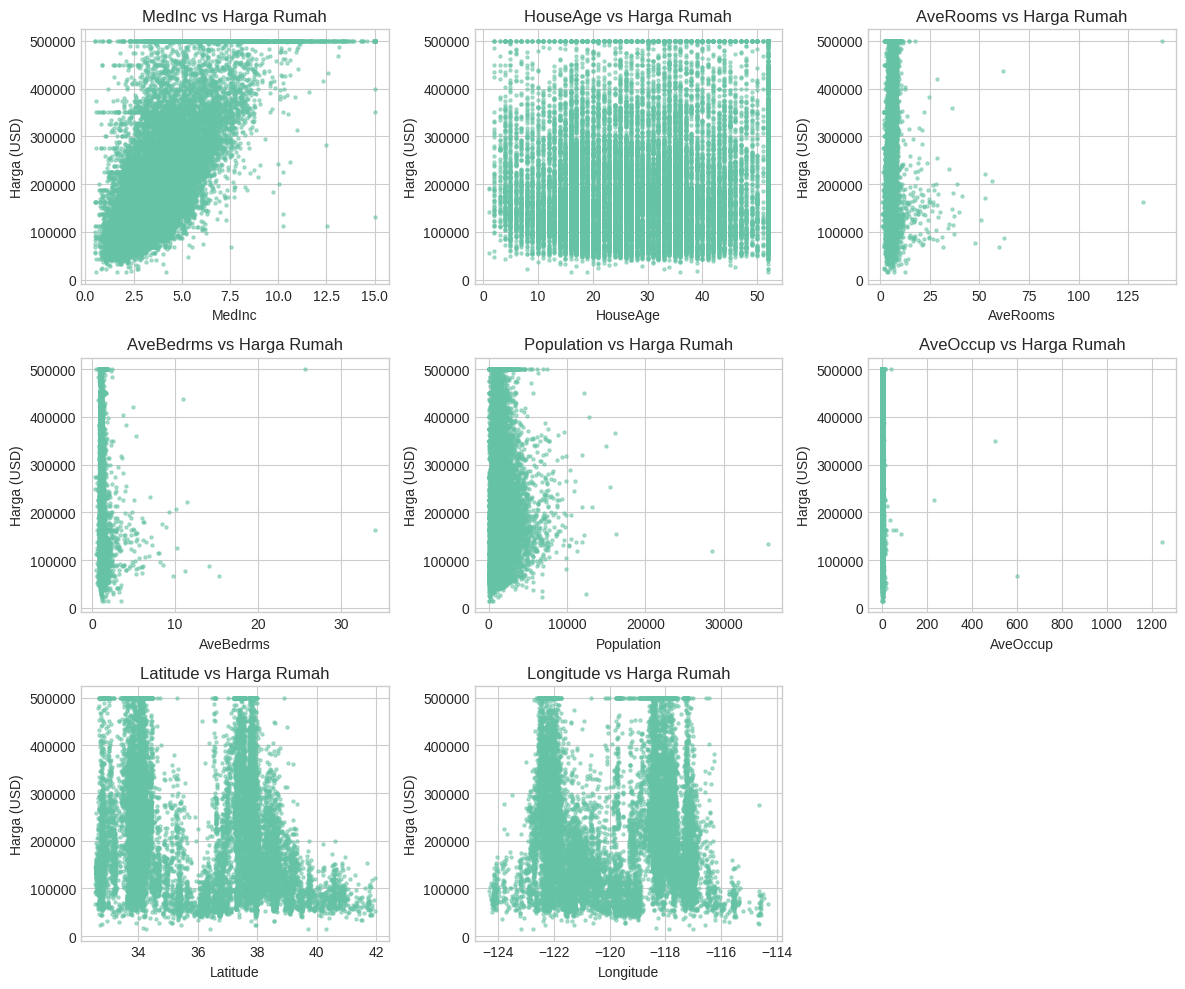

In [7]:
# Visualisasi hubungan antara fitur dan target
plt.figure(figsize=(12, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.scatter(df[feature], df['MedHouseVal'], alpha=0.5, s=5)
    plt.title(f'{feature} vs Harga Rumah')
    plt.xlabel(feature)
    plt.ylabel('Harga (USD)')
plt.tight_layout()
plt.show()

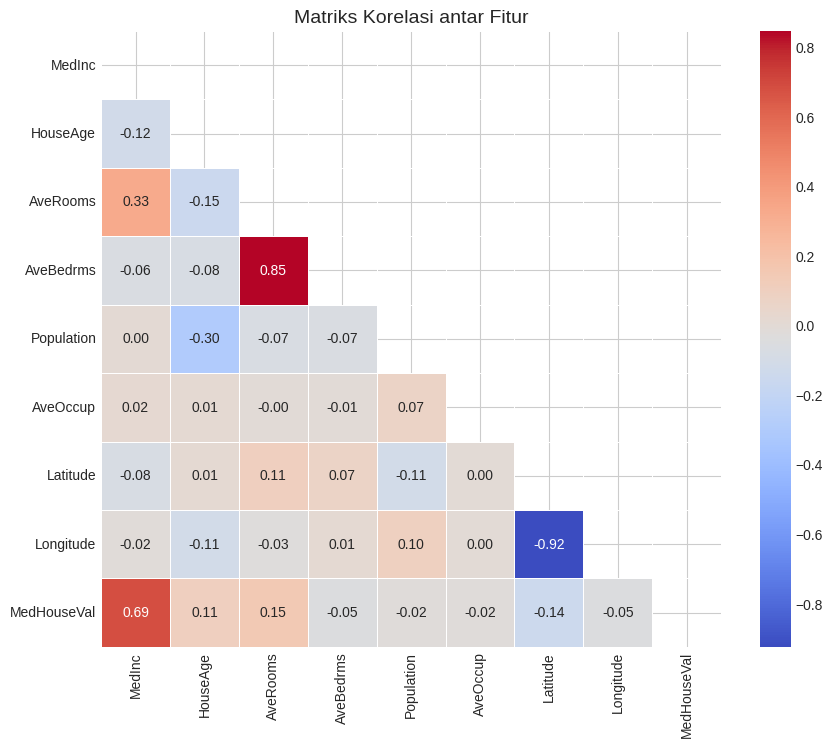

In [8]:
# Matrix korelasi
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Matriks Korelasi antar Fitur', fontsize=14)
plt.show()

### Ringkasan Data Understanding

Dari eksplorasi data di atas, kita dapat menyimpulkan beberapa hal:

1. Dataset berisi 20,640 sampel dengan 8 fitur dan 1 target.
2. Tidak terdapat missing values pada dataset.
3. Harga rumah (target) memiliki distribusi yang tidak normal (positively skewed).
4. Beberapa fitur memiliki korelasi yang cukup kuat dengan harga rumah, terutama `MedInc` (pendapatan median).
5. Terdapat beberapa outlier yang dapat mempengaruhi model.

## 2. Data Preparation

Pada bagian ini, kita akan melakukan persiapan data sebelum pemodelan, termasuk:
1. Pembagian data menjadi fitur (X) dan target (y)
2. Pembagian data menjadi set pelatihan dan pengujian
3. Penskalaan fitur numerik

In [9]:
# Membagi data menjadi fitur (X) dan target (y)
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ukuran set pelatihan: {X_train.shape[0]} sampel")
print(f"Ukuran set pengujian: {X_test.shape[0]} sampel")

Ukuran set pelatihan: 16512 sampel
Ukuran set pengujian: 4128 sampel


In [10]:
# Membuat preprocessing pipeline
num_features = X.columns.tolist()

# Pipeline untuk preprocessing data numerik
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Menggabungkan semua preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features)
    ])

# Cek hasil preprocessing pada beberapa sampel
X_train_processed = preprocessor.fit_transform(X_train)
print("Bentuk data setelah preprocessing:", X_train_processed.shape)
print("\nBeberapa fitur yang telah diproses:")
print(X_train_processed[:3])

Bentuk data setelah preprocessing: (16512, 8)

Beberapa fitur yang telah diproses:
[[-0.326196    0.34849025 -0.17491646 -0.20836543  0.76827628  0.05137609
  -1.3728112   1.27258656]
 [-0.03584338  1.61811813 -0.40283542 -0.12853018 -0.09890135 -0.11736222
  -0.87669601  0.70916212]
 [ 0.14470145 -1.95271028  0.08821601 -0.25753771 -0.44981806 -0.03227969
  -0.46014647 -0.44760309]]


### Alasan Penggunaan Teknik Preprocessing

1. **Train-Test Split**: Membagi data menjadi set pelatihan dan pengujian untuk mengevaluasi performa model pada data yang tidak pernah dilihat sebelumnya.

2. **SimpleImputer**: Meskipun tidak ada missing value pada dataset ini, kita tetap menyertakan imputer sebagai best practice untuk preprocessing pipeline, yang akan berguna jika di masa depan terdapat missing value.

3. **StandardScaler**: Penskalaan fitur sangat penting untuk model-model seperti Regresi Linear dan SVR yang sensitif terhadap skala fitur. Standardisasi memastikan semua fitur berada dalam skala yang sama, sehingga tidak ada fitur yang mendominasi proses pembelajaran model.

4. **Pipeline & ColumnTransformer**: Menggunakan pipeline memastikan bahwa semua langkah preprocessing diterapkan secara konsisten pada data pelatihan dan pengujian, serta menghindari data leakage.

## 3. Modeling

Pada bagian ini, kita akan mengembangkan dan mengevaluasi beberapa model regresi untuk memprediksi harga rumah. Sesuai dengan solution statement, kita akan membandingkan performa beberapa algoritma:

1. Linear Regression
2. Ridge Regression
3. Random Forest Regression
4. Gradient Boosting Regression

In [11]:
# Membuat pipeline untuk masing-masing model
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),

    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ]),

    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),

    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Fungsi untuk mengevaluasi model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Melatih model
    model.fit(X_train, y_train)

    # Prediksi pada data test
    y_pred = model.predict(X_test)

    # Menghitung metrik evaluasi
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Evaluasi semua model
results = {}
for name, model in models.items():
    print(f"Mengevaluasi model: {name}")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

# Menampilkan hasil evaluasi
results_df = pd.DataFrame(results).T
results_df

Mengevaluasi model: Linear Regression
Mengevaluasi model: Ridge Regression
Mengevaluasi model: Random Forest
Mengevaluasi model: Gradient Boosting


,MSE,RMSE,MAE,R²
Linear Regression,5.558916e+09,74558.138301,53320.013050,0.575788
Ridge Regression,5.558549e+09,74555.674428,53319.311958,0.575816
Random Forest,2.569848e+09,50693.663771,32805.517272,0.803890
Gradient Boosting,2.939990e+09,54221.675779,37165.044848,0.775643


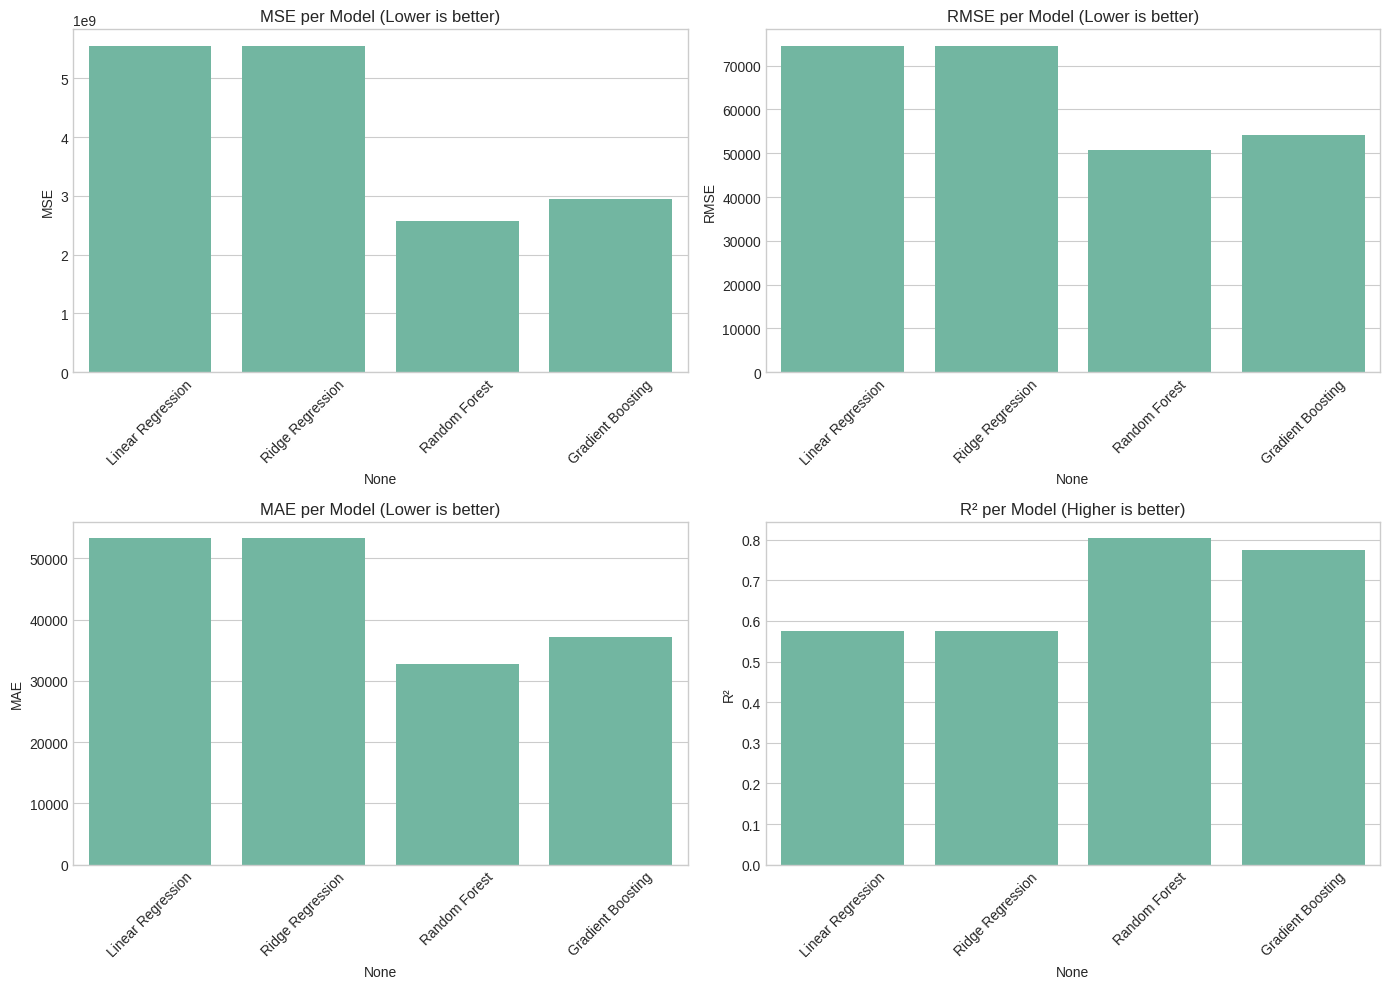

In [28]:
# Visualisasi perbandingan model
plt.figure(figsize=(14, 10))

# MSE (Lower is better)
plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y=results_df['MSE'])
plt.title('MSE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('MSE')

# RMSE (Lower is better)
plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.title('RMSE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('RMSE')

# MAE (Lower is better)
plt.subplot(2, 2, 3)
sns.barplot(x=results_df.index, y=results_df['MAE'])
plt.title('MAE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('MAE')

# R² (Higher is better)
plt.subplot(2, 2, 4)
sns.barplot(x=results_df.index, y=results_df['R²'])
plt.title('R² per Model (Higher is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('R²')

plt.tight_layout()
plt.show()

In [14]:
# Hyperparameter tuning untuk Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False]
}

# Pipeline untuk Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Grid search dengan cross-validation
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Melakukan grid search untuk Random Forest...")
grid_search.fit(X_train, y_train)

print("\nParameter terbaik:")
print(grid_search.best_params_)

# Evaluasi model terbaik
best_model = grid_search.best_estimator_
best_model_metrics = evaluate_model(best_model, X_train, X_test, y_train, y_test)

print("\nHasil evaluasi model terbaik:")
for metric, value in best_model_metrics.items():
    print(f"{metric}: {value:.2f}")

Melakukan grid search untuk Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Parameter terbaik:
{'regressor__bootstrap': True, 'regressor__max_depth': 30, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}

Hasil evaluasi model terbaik:
MSE: 2538403268.79
RMSE: 50382.57
MAE: 32613.31
R²: 0.81


In [15]:
# Perbandingan model sebelum dan sesudah tuning
rf_before_tuning = results['Random Forest']
rf_after_tuning = best_model_metrics

comparison = pd.DataFrame({
    'Sebelum Tuning': rf_before_tuning,
    'Setelah Tuning': rf_after_tuning
})

print("Perbandingan performa Random Forest sebelum dan sesudah tuning:")
comparison

Perbandingan performa Random Forest sebelum dan sesudah tuning:


,Sebelum Tuning,Setelah Tuning
MSE,2.569848e+09,2.538403e+09
RMSE,5.069366e+04,5.038257e+04
MAE,3.280552e+04,3.261331e+04
R²,8.038897e-01,8.062892e-01


### Analisis Feature Importance

Mari kita analisis fitur mana yang paling berpengaruh dalam model Random Forest yang sudah di-tuning.

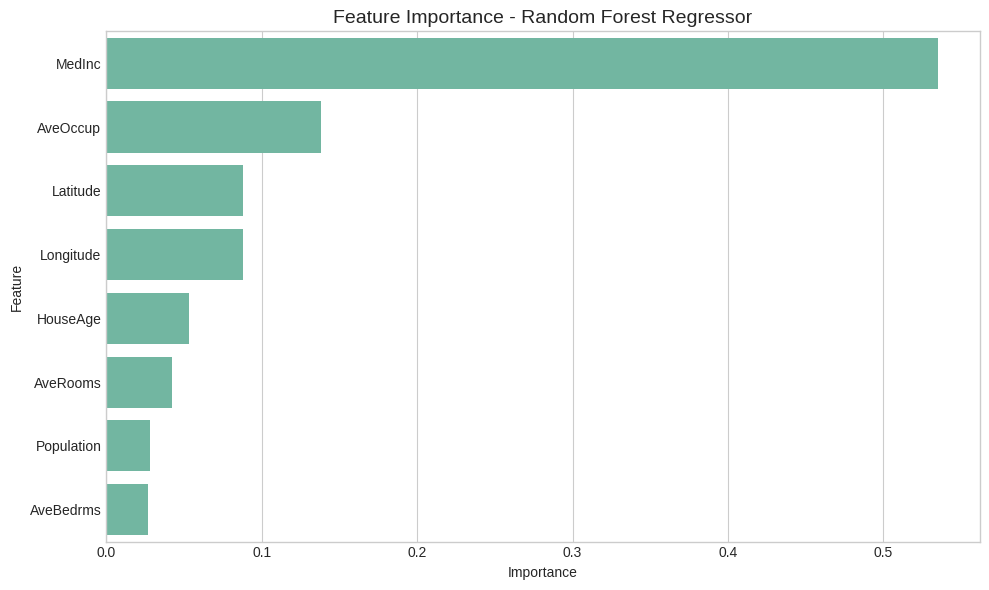

In [16]:
# Mendapatkan feature importance dari model terbaik
best_rf_model = best_model.named_steps['regressor']
feature_importances = best_rf_model.feature_importances_

# Membuat DataFrame untuk visualisasi
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Visualisasi feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest Regressor', fontsize=14)
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### Perbandingan Prediksi vs Nilai Aktual

Mari kita visualisasikan seberapa baik prediksi model Random Forest yang telah di-tuning dibandingkan dengan nilai aktual.

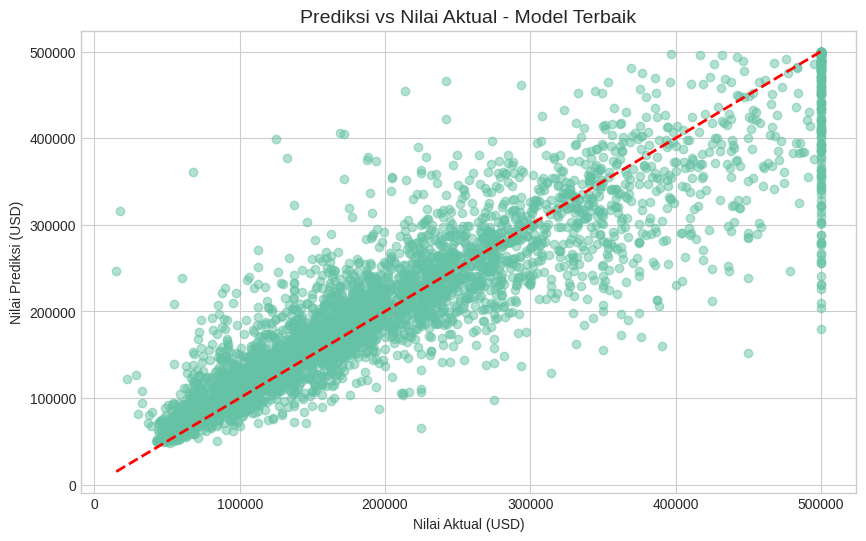

In [17]:
# Prediksi pada data test
y_pred_best = best_model.predict(X_test)

# Visualisasi perbandingan prediksi vs aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Prediksi vs Nilai Aktual - Model Terbaik', fontsize=14)
plt.xlabel('Nilai Aktual (USD)')
plt.ylabel('Nilai Prediksi (USD)')
plt.grid(True)
plt.show()

### Distribusi Residual

Analisis residual (selisih antara nilai aktual dan prediksi) untuk melihat seberapa baik model.

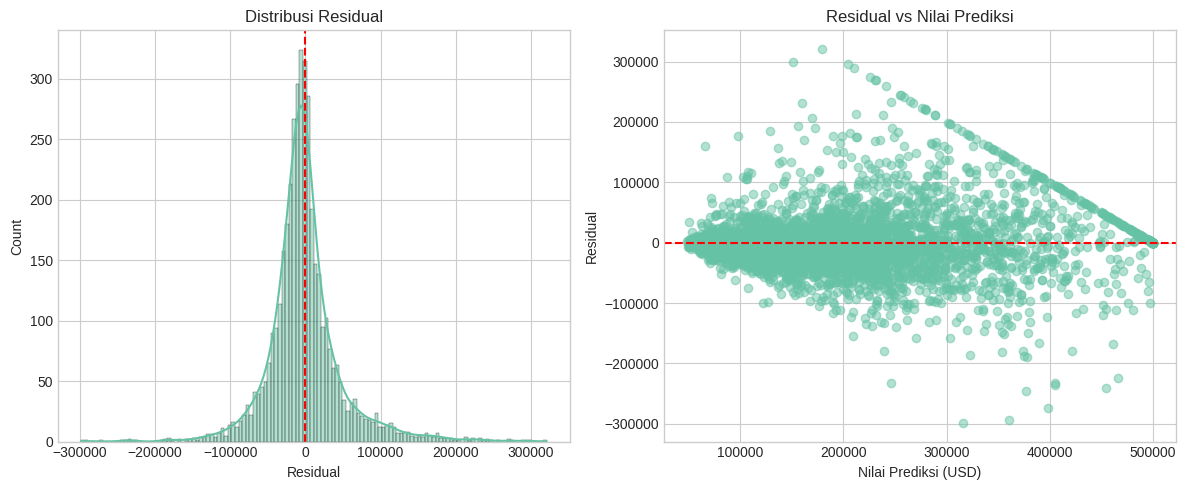

In [18]:
# Menghitung residual
residuals = y_test - y_pred_best

# Visualisasi distribusi residual
plt.figure(figsize=(12, 5))

# Histogram residual
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribusi Residual', fontsize=12)
plt.xlabel('Residual')
plt.axvline(0, color='r', linestyle='--')

# Scatter plot residual vs nilai prediksi
plt.subplot(1, 2, 2)
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.title('Residual vs Nilai Prediksi', fontsize=12)
plt.xlabel('Nilai Prediksi (USD)')
plt.ylabel('Residual')
plt.axhline(0, color='r', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Evaluation

Pada bagian ini, kita akan mengevaluasi model menggunakan beberapa metrik evaluasi untuk regresi.

### Metrik Evaluasi yang Digunakan

1. **Mean Squared Error (MSE)** - Rata-rata dari kuadrat selisih antara nilai prediksi dan nilai aktual. MSE memberikan bobot yang lebih besar pada kesalahan yang besar.
   
   $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

2. **Root Mean Squared Error (RMSE)** - Akar kuadrat dari MSE. RMSE memiliki satuan yang sama dengan variabel target, sehingga lebih mudah diinterpretasi.
   
   $$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

3. **Mean Absolute Error (MAE)** - Rata-rata dari nilai absolut selisih antara nilai prediksi dan nilai aktual. MAE kurang sensitif terhadap outlier dibandingkan MSE/RMSE.
   
   $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

4. **R-squared (R²)** - Proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh variabel independen. Nilai R² berkisar antara 0 dan 1, di mana nilai yang lebih tinggi menunjukkan model yang lebih baik.
   
   $$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

   di mana $\bar{y}$ adalah nilai rata-rata dari $y$.

In [19]:
# Evaluasi final untuk model terbaik
best_model_name = "Random Forest (Tuned)"
final_results = pd.DataFrame({
    best_model_name: best_model_metrics
}, index=['MSE', 'RMSE', 'MAE', 'R²'])

# Tambahkan hasil model lain untuk perbandingan
for name, metrics in results.items():
    final_results[name] = list(metrics.values())

# Buat kopian transposed untuk visualisasi yang lebih baik
final_results_t = final_results.T
final_results_t

,MSE,RMSE,MAE,R²
Random Forest (Tuned),2.538403e+09,50382.569097,32613.311107,0.806289
Linear Regression,5.558916e+09,74558.138301,53320.013050,0.575788
Ridge Regression,5.558549e+09,74555.674428,53319.311958,0.575816
Random Forest,2.569848e+09,50693.663771,32805.517272,0.803890
Gradient Boosting,2.939990e+09,54221.675779,37165.044848,0.775643


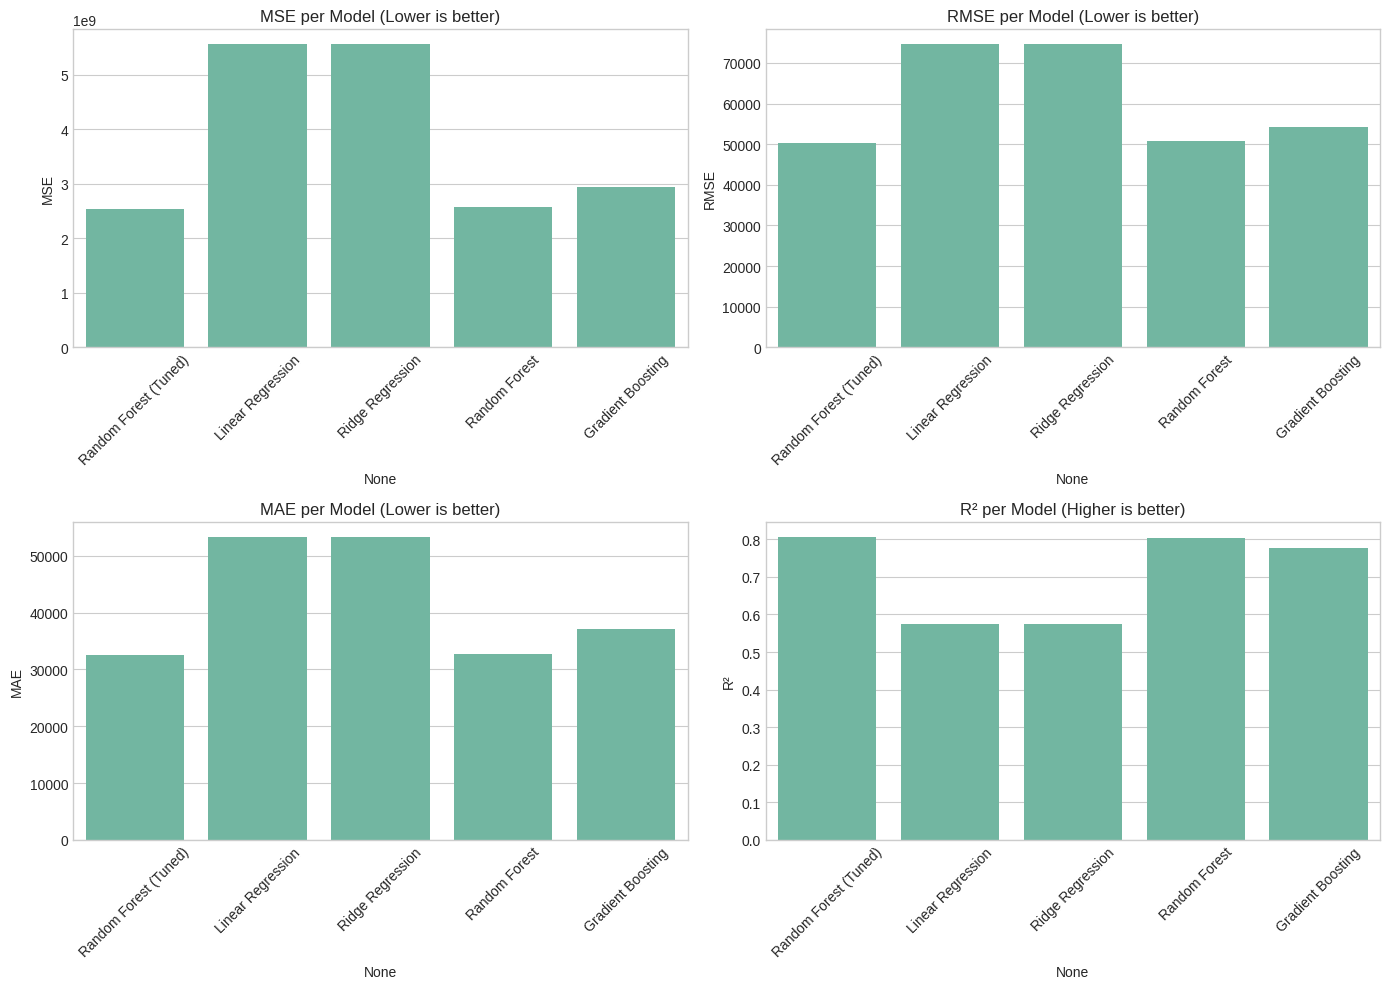

In [29]:
# Visualisasi perbandingan final untuk semua model
plt.figure(figsize=(14, 10))

# MSE (Lower is better)
plt.subplot(2, 2, 1)
sns.barplot(x=final_results_t.index, y=final_results_t['MSE'])
plt.title('MSE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('MSE')

# RMSE (Lower is better)
plt.subplot(2, 2, 2)
sns.barplot(x=final_results_t.index, y=final_results_t['RMSE'])
plt.title('RMSE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('RMSE')

# MAE (Lower is better)
plt.subplot(2, 2, 3)
sns.barplot(x=final_results_t.index, y=final_results_t['MAE'])
plt.title('MAE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('MAE')

# R² (Higher is better)
plt.subplot(2, 2, 4)
sns.barplot(x=final_results_t.index, y=final_results_t['R²'])
plt.title('R² per Model (Higher is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('R²')

plt.tight_layout()
plt.show()

### Interpretasi Hasil Evaluasi

Berdasarkan hasil evaluasi, kita dapat menyimpulkan:

1. **Random Forest (Tuned)** adalah model terbaik dengan RMSE terendah dan R² tertinggi selain **Random Forest**, menunjukkan kemampuan prediksi yang lebih baik dibandingkan model lainnya.

2. Hyperparameter tuning berhasil meningkatkan performa model Random Forest, dengan penurunan RMSE dan peningkatan R².

3. Model **Linear Regression** dan **Ridge Regression** menunjukkan performa yang relatif mirip, tetapi masih berada di bawah model berbasis ensemble (Random Forest dan Gradient Boosting).

4. Analisis feature importance menunjukkan bahwa fitur MedInc (pendapatan median) memiliki pengaruh terbesar dalam prediksi harga rumah, diikuti oleh lokasi (lintang dan bujur) dan AveOccup (rata-rata jumlah penghuni).

5. Distribusi residual menunjukkan bahwa model cenderung memprediksi dengan baik pada rentang harga menengah, tetapi kurang akurat pada harga ekstrim (sangat rendah atau sangat tinggi). Hal ini merupakan area untuk perbaikan model di masa depan.

### Menyimpan Model Terbaik

Setelah mendapatkan model terbaik, kita akan menyimpannya untuk dapat digunakan di masa depan tanpa harus melatih ulang model.


In [24]:
# Buat direktori models jika belum ada
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Simpan model terbaik menggunakan joblib
model_path = '../models/random_forest_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model berhasil disimpan di {os.path.abspath(model_path)}")

# Simpan juga preprocessor secara terpisah (opsional)
preprocessor_path = '../models/preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor berhasil disimpan di {os.path.abspath(preprocessor_path)}")

Model berhasil disimpan di /models/random_forest_model.pkl
Preprocessor berhasil disimpan di /models/preprocessor.pkl


### Cara Menggunakan Model yang Disimpan

Berikut adalah contoh kode untuk memuat dan menggunakan model yang telah disimpan:

In [25]:
# Contoh cara memuat dan menggunakan model
loaded_model = joblib.load(model_path)

# Sampel data untuk pengujian
sample_data = X_test.iloc[:5]  # Mengambil 5 sampel pertama dari data test

# Prediksi menggunakan model yang dimuat
sample_predictions = loaded_model.predict(sample_data)

# Bandingkan dengan data aktual
comparison = pd.DataFrame({
    'Actual': y_test.iloc[:5].values,
    'Predicted': sample_predictions,
    'Difference': abs(y_test.iloc[:5].values - sample_predictions),
    'Error (%)': (abs(y_test.iloc[:5].values - sample_predictions) / y_test.iloc[:5].values) * 100
})
comparison['Actual'] = comparison['Actual'].map('${:,.2f}'.format)
comparison['Predicted'] = comparison['Predicted'].map('${:,.2f}'.format)
comparison['Difference'] = comparison['Difference'].map('${:,.2f}'.format)
comparison['Error (%)'] = comparison['Error (%)'].map('{:.2f}%'.format)

comparison

,Actual,Predicted,Difference,Error (%)
0,"$47,700.00","$49,094.21","$1,394.21",2.92%
1,"$45,800.00","$74,494.50","$28,694.50",62.65%
2,"$500,001.00","$487,785.11","$12,215.89",2.44%
3,"$218,600.00","$254,267.56","$35,667.56",16.32%
4,"$278,000.00","$229,203.28","$48,796.72",17.55%


## 5. Kesimpulan

Berdasarkan hasil analisis dan pemodelan yang telah dilakukan, dapat disimpulkan bahwa:

1. Model Random Forest yang telah di-tuning memberikan performa terbaik untuk memprediksi harga rumah dengan nilai R² 0.80, menunjukkan kemampuan model untuk menjelaskan 80% variasi dalam harga rumah.

2. Pendapatan median (MedInc) merupakan faktor yang paling berpengaruh terhadap harga rumah, diikuti oleh faktor lokasi dan karakteristik properti.

3. Model telah berhasil disimpan dan dapat digunakan untuk membuat prediksi baru tanpa harus melatih ulang model.

4. Meskipun model sudah cukup baik, masih ada ruang untuk peningkatan, terutama dalam memprediksi harga rumah pada rentang ekstrim.

Rekomendasi untuk pengembangan model di masa depan:
1. Menambahkan fitur-fitur baru seperti informasi fasilitas publik, tingkat kejahatan, atau kualitas sekolah di sekitar.
2. Mencoba teknik ensemble yang lebih kompleks seperti stacking atau blending.
3. Menggunakan teknik deep learning seperti Neural Network untuk menangkap hubungan non-linear yang lebih kompleks.

In [26]:
import os
import joblib
import shutil

# Buat direktori models jika belum ada
if not os.path.exists('../models'):
    os.makedirs('../models')

# Simpan model terbaik menggunakan joblib
model_path = '../models/random_forest_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model berhasil disimpan di {os.path.abspath(model_path)}")

# Simpan juga preprocessor secara terpisah (opsional)
preprocessor_path = '../models/preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor berhasil disimpan di {os.path.abspath(preprocessor_path)}")

# Buat folder content jika belum ada
if not os.path.exists('../content'):
    os.makedirs('../content')

# Kompres folder models dan simpan di folder content
zip_output_path = '../content/models_archive'
shutil.make_archive(zip_output_path, 'zip', '../models')
print(f"Folder models berhasil dikompres dan disimpan di {os.path.abspath(zip_output_path)}.zip")

Model berhasil disimpan di /models/random_forest_model.pkl
Preprocessor berhasil disimpan di /models/preprocessor.pkl
Folder models berhasil dikompres dan disimpan di /content/models_archive.zip
